## Basic HDDM Tutorial

In the following we will show an example session of using HDDM to analyze a real-world dataset. The main purpose is to provide an overview of some of the funcionality and interface. By no means, however, is it a complete overview of all the functionality in HDDM. For more information, including on how to use HDDM as a command-line utility, we refer to the online tutorial at http://ski.clps.brown.edu/hddm_docs/tutorial.html and the how-to at http://ski.clps.brown.edu/hddm_docs/howto.html. For a reference manual, see http://ski.clps.brown.edu/hddm_docs.

First, we have to import the modules we are going to use so that they are available in our namespace. Pandas provides a table-oriented data-structure and matplotlib is a module for generating graphs and plots.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Next, we will import HDDM. At the time of this writing, this version was used.

In [3]:
%matplotlib inline
import hddm

print(hddm.__version__)

0.9.6


### Loading data

Next, we will load in a data set. The easiest way to get your data
into HDDM is by storing it in a csv (comma-separated-value, see below) file. In this example we will be using data collected
in a reward-based decision making experiment in our lab (Cavanagh et al 2011). In brief, subjects choose between two symbols that have different histories of reinforcement, which they first acquire through a learning phase: some symbols more often leads to wins  (W; 80%, 70% and 60% of trials in which they are selected), whereas others only lead to win on 40%, 30%, or 20% of the time and otherwise lead to losses (L). A test phase ensures in which subjects choose between all paired combination of symbols without feedback. These test trials can be devided into win-win (WW) trials, in which they select between two symbols that had led to wins before (but one more often than another); lose-lose trials (LL), and win-lose (WL) trials, which are the easiest because one symbol had been a winner most of the time. Thus WW and LL decisions together comprise high conflict (HC) test trials (although there are other differences between them, we don't focus on those here), whereas WL decisions are low conflict (LC).  The main hypothesis of the study was that high conflict trials induce an increase in the decision threshold, and that the mechanism for this threshold modulation depends on communication between mediofrontal cortex (which exhibits increased activity under conditions of choice uncertainty or conflict) and the subthalamic nucleus (STN) of the basal ganglia (which provides a temporary brake on response selection by increasing the decision threshold). The details of this mechanism are described in other modeling papers (e.g., Ratcliff & Frank 2012). Cavanagh et al 2011 tested this theory by measuring EEG activity over mid-frontal cortex, focusing on the theta band, given prior associations with conflict, and testing whether trial-to-trial variations in frontal theta were related to adjustments in decision threshold during high conflict trials. They tested the STN component of the theory by administering the same experiment to patients who had deep brain stimulation (dbs) of the STN, which interferes with normal processing.  

The first ten lines of the data file look as follows:

In [4]:
!head cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


We use the ``hddm.load_csv()`` function to load this file.

In [5]:
data = hddm.load_csv("./cavanagh_theta_nn.csv")

In [6]:
data.head(10)

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
5,0,WL,1.150,1.0,-0.436204,1,LC
6,0,LL,2.000,1.0,-0.274479,1,HC
7,0,WL,1.040,0.0,0.666957,1,LC
8,0,WW,0.857,1.0,0.118617,1,HC
9,0,WL,1.500,0.0,0.823626,1,LC


Lets look at the RT distributions of each individual subject using pandas' `groupby()` functionality. Because there are two possible responses (here we are using accuracy coding where 1 means the more rewarding symbol was chosen,  and 0 the less rewarding) we flip error RTs to be negative. 

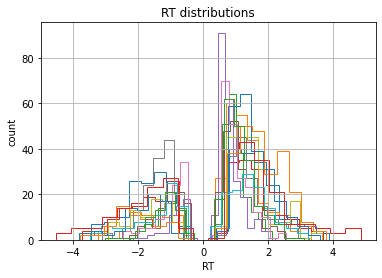

In [7]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="RT", ylabel="count", title="RT distributions")
for i, subj_data in data.groupby("subj_idx"):
    subj_data.rt.hist(bins=20, histtype="step", ax=ax)

plt.savefig("hddm_demo_fig_00.pdf")

### Fitting a hierarchical model

Lets fit a hierarchical DDM to this data set, starting off first with the simplest model that does not allow parameters to vary by condition.

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).

# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 2000 samples and discarding 20 as burn-in (usually you want to have a longer burn-in period)
m.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Set model to ddm


/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 328.2 sec

We now want to analyze our estimated model. `m.print_stats()` will print a table of summary statistics for each parameters' posterior. Because that is quite long we only print a subset of the parameters using pandas selection functionality.

In [9]:
stats = m.gen_stats()
stats[stats.index.isin(["a", "a_std", "a_subj.0", "a_subj.1"])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97542,0.0940424,1.79218,1.91573,1.97419,2.03497,2.17103,0.00219092
a_std,0.33827,0.0770823,0.220386,0.285276,0.326261,0.380676,0.527831,0.00257471
a_subj.0,2.20059,0.0648662,2.07624,2.15591,2.20029,2.24381,2.33027,0.00200121
a_subj.1,2.11078,0.0644109,1.9864,2.06509,2.11072,2.15448,2.2363,0.00192041


As you can see, the model estimated the group mean parameter for threshold `a`, group variability `a_std` and individual subject parameters `a_subj.0`. Other parameters are not shown here.

The inference algorithm, MCMC, requires the chains of the model to have properly converged. While there is no way to guarantee convergence for a finite set of samples in MCMC,  there are many heuristics that allow you identify problems of convergence. One main analysis to look at is the trace, the autocorrelation, and the marginal posterior. You can plot these using the `plot_posteriors()` function. For the sake of brevity we only plot three here. In practice, however, you will always want to examine all of them.

Plotting a
Plotting a_std
Plotting v
Plotting t


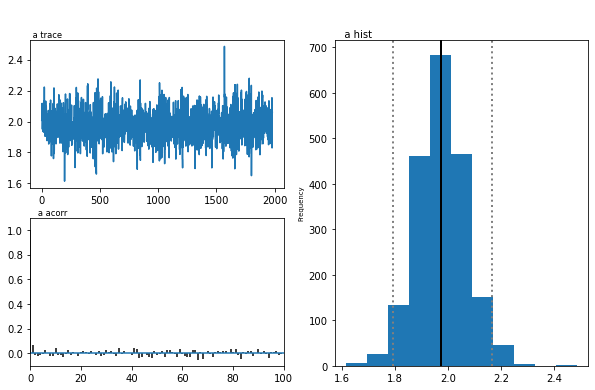

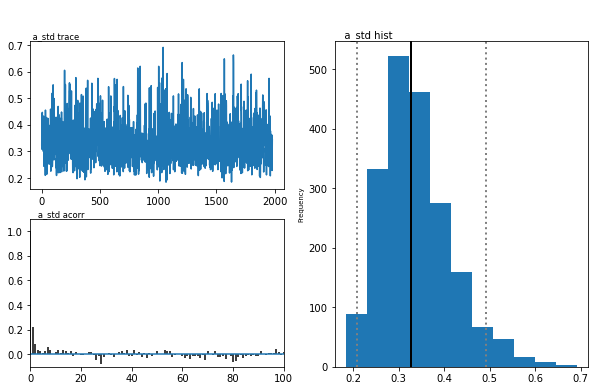

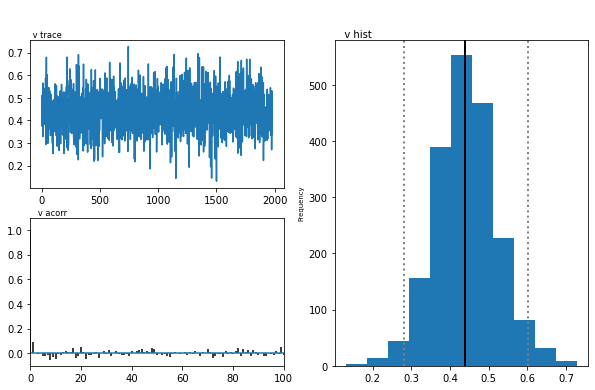

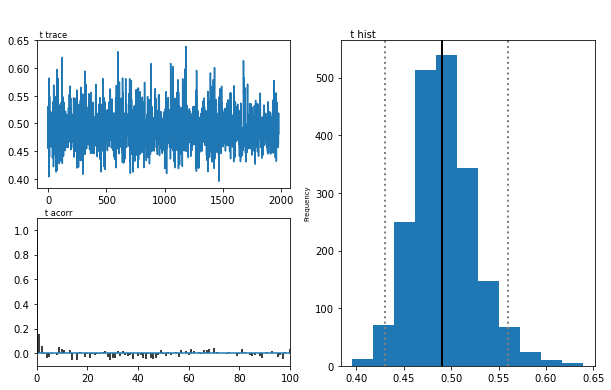

In [10]:
m.plot_posteriors(["a", "t", "v", "a_std"])

As you can see, there are no drifts or large jumps in the trace. The autocorrelation is also very low.

The Gelman-Rubin statistic provides a more formal test for convergence that compares the intra-chain variance to the intra-chain variance of different runs of the same model.

In [39]:
models = []
for i in range(5):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(2000, burn=500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to ddm


/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 284.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 314.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 315.9 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 224.1 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2001 of 2000 complete in 219.4 sec

{'a': 0.9998303182212243,
 'a_std': 1.000302900736453,
 'a_subj.0': 0.9997302281455774,
 'a_subj.1': 1.000210960096837,
 'a_subj.2': 1.0000893900199943,
 'a_subj.3': 1.0000376067768229,
 'a_subj.4': 1.001288709935588,
 'a_subj.5': 1.0000714056352387,
 'a_subj.6': 1.0007846805440694,
 'a_subj.7': 1.0004646343952772,
 'a_subj.8': 1.0023483983425399,
 'a_subj.9': 0.9997680215565935,
 'a_subj.10': 0.9999889337044247,
 'a_subj.11': 0.9999177658948148,
 'a_subj.12': 1.000161133243421,
 'a_subj.13': 1.0006337627947017,
 'v': 0.9999569890550272,
 'v_std': 0.9998101298324256,
 'v_subj.0': 1.000091518454496,
 'v_subj.1': 1.000439110921408,
 'v_subj.2': 0.9998690492069756,
 'v_subj.3': 0.9997795055437586,
 'v_subj.4': 1.0005037511250383,
 'v_subj.5': 1.0000666885634026,
 'v_subj.6': 1.00088768074011,
 'v_subj.7': 1.0001014006051618,
 'v_subj.8': 0.9997181792217363,
 'v_subj.9': 0.9998569851609095,
 'v_subj.10': 1.0004447099624747,
 'v_subj.11': 1.0003295986709129,
 'v_subj.12': 0.9998716245752058

We might also be interested in how well the model fits the data. To inspect this visually you can call `plot_posterior_predictive()` to plot individual subject RT distributions in red on top of the predictive likelihood in blue.

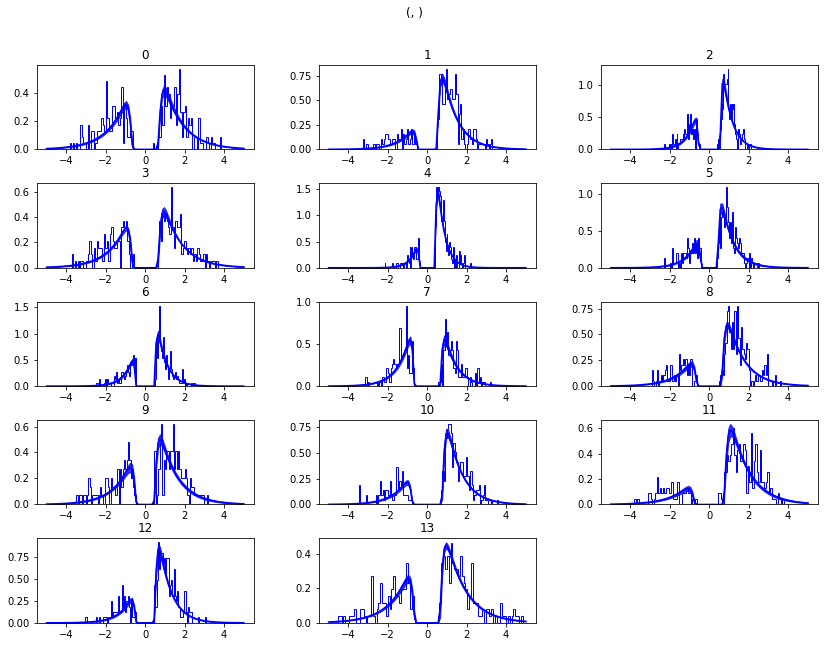

In [11]:
m.plot_posterior_predictive(figsize=(14, 10))

While visually the fit looks decent, we also have prior knowledge about our experiment which could be leveraged to improve the model. For example, we would expect that because LL and WW trials are harder than WL trials, drift rate would be higher in WL, which has lower uncertainty about the correct choice. (One could also develop a posterior predictive check statistic that would evaluate whether accuracy and mean RT are different in the different conditions. Since the parameters of the model were estimated to be the same across conditions, the posterior predictive distributions for these conditions would not look different from each other, whereas those in the data do. A formal posterior predictive check would thus show that the data violates the simple assumptions of the model. This is not evident above because we simply plotted the distributions collapsed across conditions). 

In any case, we can create a new model quite easily which estimates separate drift-rate `v` for those different conditions by using the `depends_on` keyword argument. This argument expects a Python `dict` which maps the parameter to be split to the column name containing the conditions we want to split by.

In [12]:
m_stim = hddm.HDDM(data, depends_on={"v": "stim"})
m_stim.find_starting_values()
m_stim.sample(2000, burn=100)

No model attribute --> setting up standard HDDM
Set model to ddm


/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 793.3 sec

We will skip examining the traces for this model and instead look at the posteriors of `v` for the different conditions. Below you can see that the drift rate for the low conflict WL condition is substantially greater than that for the other two conditions, which are fairly similar to each other.

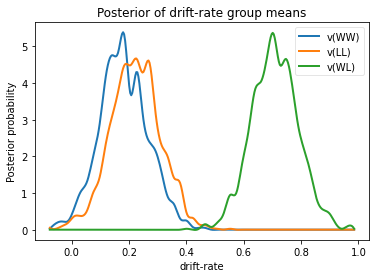

In [14]:
v_WW, v_LL, v_WL = m_stim.nodes_db.node[["v(WW)", "v(LL)", "v(WL)"]]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Posterior of drift-rate group means")
plt.savefig("hddm_demo_fig_06.pdf")

While it would be easy to provide syntacic sugar for the above expression there are many cases where you want access to the underlying distributions. These are stored inside of `nodes_db` which is a pandas `DataFrame` containing information about each distribution. Here we retrieve the actual node objects containing the trace from the `node` colum.

One benefit of estimating the model in a Bayesian framework is that we can do significance testing directly on the posterior rather than relying on frequentist statistics (See Kruschke's book for many examples of the advantages of this approach). For example, we might be interested in whether the drift-rate for WW is larger than that for LL, or whether drift-rate for LL is larger than WL. The below code allows us to examine the proportion of the posteriors in which the drift rate for one condition is greater than the other. It can be seen that the posteriors for LL do not overlap at all for WL, and thus the probability that LL is greater than WL should be near zero.

In [15]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.36473684210526314
P(LL > WL) =  0.0


Lets compare the two models using the deviance information criterion (DIC; lower is better). Note that the DIC measures the fit of the model to the data, penalizing for complexity in the addition of degrees of freedom (the model with three drift rates has more dF than the model with one). The DIC is known to be somewhat biased in selecting the model with greater complexity, although alternative forms exist (see Plummer 2008). One should use the DIC with caution, although other forms of model comparison such as the Bayes Factor (BF) have other problems, such as being overly sensitive to the prior parameter distributions of the models. Future versions of HDDM will include the partial Bayes Factor, which allows the BF to be computed based on informative priors taken from a subset of the data, and which we generally believe to provide a better measure of model fit. Nevertheless, DIC can be a useful metric with these caveats in mind.

In [16]:
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim.dic)

Lumped model DIC: 10974.090050
Stimulus model DIC: 10786.243737


## Within-subject effects

Note that while the `m_stim` model we created above estimates different drift-rates `v` for each subject, it implicitly assumes that the different conditions are completely independent of each other, because each drift rate was sampled from a separate group prior. However, there may be individual differences in overall performance, and if so it is reasonable to assume that someone who would be better at `WL` would also be better at `LL`. To model this intuition we can use a within-subject model where an intercept is used to capture overall performance in the 'WL' condition as a baseline, and then the other `LL` and `WW` conditions are expressed relative to `WL`. (Perhaps every subject has a higher drift in WL than LL but there is huge variance in their overall drift rates. In this scenario, the earlier model would not have the power to detect the effect of condition on this within subject effect, because there would be large posterior variance in all of the drift rates, which would then overlap with each other. In contrast, the within-subject model would estimate large variance in the intercept but still allow the model to infer a non-zero effect of condition with high precision).

`HDDM` supports this via the `patsy` module which transforms model strings to design matrices.

In [17]:
from patsy import dmatrix

dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

`Patsy` model specifications can be passed to the `HDDMRegressor` class as part of a descriptor that contains the string describing the linear model and the `outcome` variable that should be replaced with the output of the linear model -- in this case `v`.

In [18]:
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")

No model attribute --> setting up standard HDDM
Set model to ddm


In [19]:
m_within_subj.sample(2000, burn=100)

 [-----------------100%-----------------] 2001 of 2000 complete in 1423.8 sec

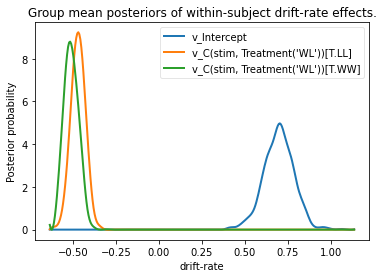

In [23]:
v_WL, v_LL, v_WW = m_within_subj.nodes_db.loc[
    [
        "v_Intercept",
        "v_C(stim, Treatment('WL'))[T.LL]",
        "v_C(stim, Treatment('WL'))[T.WW]",
    ],
    "node",
]
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel("drift-rate")
plt.ylabel("Posterior probability")
plt.title("Group mean posteriors of within-subject drift-rate effects.")
plt.savefig("hddm_demo_fig_07.pdf")

Note that in the above plot `LL` and `WW` are expressed relative to the `WL` condition (i.e. `v_Intercept`). You can see that the overall drift rate intercept, here applying to WL condition, is positive (mode value roughly 0.7), whereas the within subject effects of condition (WW and LL) are negative and do not overlap with zero.

## Fitting regression models

As mentioned above, cognitive neuroscience has embraced the DDM as it enables to link psychological processes to cognitive brain measures. The Cavanagh et al (2011) study is a great example of this. EEG recordings provided a trial-ty-trial measure of brain activity (frontal theta), and it was found that this activity correlated with increases in decision threshold in high conflict trials.  Note that the data set and results exhibit more features than we consider here for the time being (specifically the manipulation of deep brain stimulation), but for illustrative purposes, we replicate here that main theta-threshold relationship in a model restricted to participants without brain stimulation.  For more information, see http://ski.clps.brown.edu/papers/Cavanagh_DBSEEG.pdf

In [24]:
m_reg = hddm.HDDMRegressor(
    data[data.dbs == 0], "a ~ theta:C(conf, Treatment('LC'))", depends_on={"v": "stim"}
)

No model attribute --> setting up standard HDDM
Set model to ddm


Instead of estimating one static threshold per subject across trials, this model assumes the threshold to vary on each trial according to the linear model specified above (as a function of their measured theta activity). We also test whether this effect interacts with decision conflict. For the stimuli we use dummy treatment coding with the intercept being set on the WL condition. Internally, HDDM uses Patsy for the linear model specification, see the [Patsy documentation](https://patsy.readthedocs.org/en/latest/) for more details. The output notifies us about the different variables that being estimated as part of the linear model. The Cavanagh paper, and results shown later below, illustrate that this brain/behavior relationship differs as a function of whether patients are on or off STN deep brain stimulation, as hypothesized by the model that STN is responsible for increasing the decision threshold when cortical theta rises).

In [25]:
m_reg.sample(2000, burn=100)

 [--------------   38%                  ] 766 of 2000 complete in 854.2 secHalting at iteration  765  of  2000


P(a_theta < 0) =  0.02375


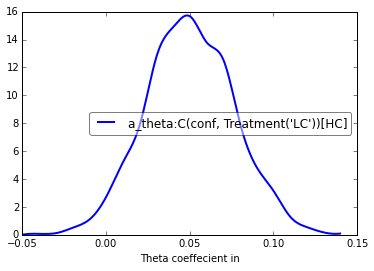

In [16]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel("Theta coeffecient in ")
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

The above posterior shows that the effect of trial to trial variations in frontal theta are to increase the estimated decision threshold: the regression coefficient is positive, and more than 96% of it is greater than zero. 

As noted above, this experiment also tested patients on deep brain stimulation (dbs). The full model in the paper thus allowed an additional factor to estimate how dbs interacts with theta-threshold relationship. Here we show for illustrative purposes that we can capture the same effect by simply fitting a separate model to data only including the case when dbs was turned on. You should see below that in this case, the influence of theta on threshold reverses. This exercise thus shows that HDDM can be used both to assess the influence of trial-by-trial brain measures on DDM parameters, but also how parameters vary when brain state is manipulated.  

In [27]:
m_reg_off = hddm.HDDMRegressor(
    data[data.dbs == 1], "a ~ theta:C(conf, Treatment('LC'))", depends_on={"v": "stim"}
)

No model attribute --> setting up standard HDDM
Set model to ddm


In [28]:
m_reg_off.sample(2000, burn=100)

 [-----------------100%-----------------] 2001 of 2000 complete in 1098.3 sec

P(a_theta > 0) =  0.05421052631578947


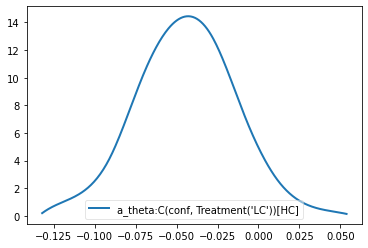

In [29]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

It is common to have outliers in any data set and RT data is no exception. Outliers present a serious challenge to likelihood-based approaches, as used in HDDM. Consider the possibility that 5% of trials are not generated by the DDM process, but by some other process (e.g. due to an attentional lapse). The observed data in those trials may be very unlikely given the best DDM parameters that fit 95% of the data. In the extreme case, the likelihood of a single trial may be zero (e.g. if subjects respond very quickly, faster than the non-decision time `t` parameter that would fit the rest of the data). Thus this single outlier would force the DDM parameters to adjust substantially.  To see the effect of this we will generate data with outliers, but fit a standard DDM model without taking outliers into account.

In [30]:
outlier_data, params = hddm.generate.gen_rand_data(
    params={"a": 2, "t": 0.4, "v": 0.5}, size=200, n_fast_outliers=10
)

/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
m_no_outlier = hddm.HDDM(outlier_data, p_outlier=0.0)
m_no_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 16.5 sec

/Users/afengler/OneDrive/project_hddm_extension/kabuki/kabuki/analyze.py:589: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')


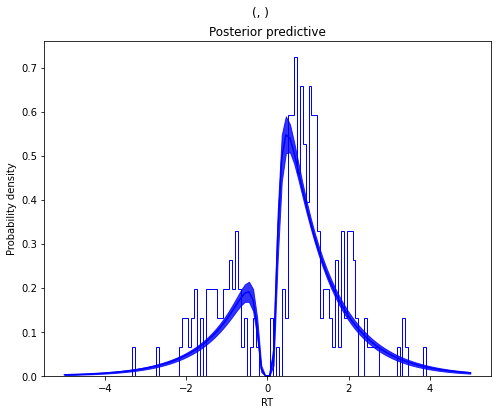

In [36]:
m_no_outlier.plot_posterior_predictive()
plt.title("Posterior predictive")
plt.xlabel("RT")
plt.ylabel("Probability density")
plt.savefig("hddm_demo_fig_10.pdf")

As you can see, the predictive likelihood does not fit the RT data very well. The model predicts far more RTs near the leading edge of the distribution than are actually observed. This is because non-decision time `t` is forced to be estimated small enough to account for a few fast RTs.  

What we can do instead is fit a mixture model which assumes that outliers come from a uniform distribution. (Note, outliers do not have to be very fast or very slow, and the above example is just an obvious illustration. Some proportion of the trials can be assumed to simply come from a different process for which we make no assumptions about its generation, and hence use a uniform distribution. This allows the model to find the best DDM parameters that capture the majority of trials).   Here, we specify that we expect roughly 5% outliers in our data.

In [37]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=0.05)
m_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 19.2 sec

/Users/afengler/OneDrive/project_hddm_extension/kabuki/kabuki/analyze.py:589: UserWarning: Too many nodes. Consider increasing number of columns.
  warnings.warn('Too many nodes. Consider increasing number of columns.')


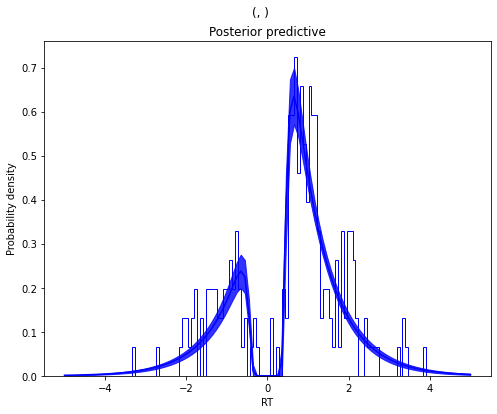

In [38]:
m_outlier.plot_posterior_predictive()
plt.title("Posterior predictive")
plt.xlabel("RT")
plt.ylabel("Probability density")
plt.savefig("hddm_demo_fig_11.pdf")

As you can see, the model provides a much better fit. The outlier RTs are having less of an effect because they get assigned to the uniform outlier distribution. 